In [1]:
import numpy as np
import os
from numpy import genfromtxt
from pathlib import Path
import math
from scipy.signal import savgol_filter

In [2]:
#  Functions

def eulers_2_rot_matrix(x):
    """
    EULER_2_ROT_MATRIX transforms a set of euler angles into a rotation  matrix 
    input vector of euler angles 
    [gamma_x, beta_y, alpha_z]  are ZYX Eulers angles in radians
    """
    gamma_x=x[0];beta_y=x[1];alpha_z=x[2];
    rot_z = rotz(alpha_z)
    rot_y = roty(beta_y)
    rot_x = rotx(gamma_x)
    
    R = rot_z * rot_y * rot_x
    return R

def rotx(t):
    # ROTX Rotation about X axis
    ct = math.cos(t);
    st = math.sin(t);
    r =  np.matrix([[1,	0,	0],
                    [0,	ct,	-st],
                    [0,	st,	ct]]);
    return r

def roty(t):
    # ROTY Rotation about Y axis
    ct = math.cos(t);
    st = math.sin(t);
    r =  np.matrix([[ct,	0,	st],
                    [0,	1,	0],
                    [-st	,0,	ct]]);
    return r

def rotz(t):
    # ROTZ Rotation about Z axis
    ct = math.cos(t);
    st = math.sin(t);
    r = np.matrix([[ct, -st, 0],
                   [st, ct, 0],
                   [0, 0, 1]]);
    return r
    

# Kinect data only has only one absolute position so we need to calculate absolute positions for remaining
def rel2abs_kinect(pos, ang, skel):
    num_joints, dimensions, num_frames = skel.shape
    for i in range(num_frames):
        """
        1 Waist (absolute)
        2 Spine
        3 Chest
        4 Neck
        5 Head
        6 Head tip
        7 Left collar
        8 Left upper arm 
        9 Left forearm
        10 Left hand
        11 Right collar
        12 Right upper arm 
        13 Right forearm
        14 Right hand
        15 Left upper leg 
        16 Left lower leg 
        17 Left foot 
        18 Left leg toes
        19 Right upper leg 
        20 Right lower leg 
        21 Right foot
        22 Right leg toes
        """
        joint = pos[:,:,i]
        joint_ang = ang[:,:,i]
        
        # chest, neck, head
        rot_1 = eulers_2_rot_matrix(joint_ang[0,:]*np.pi/180)
        joint[1,:] =  rot_1@joint[1,:] + joint[0,:]
        rot_2 = rot_1*eulers_2_rot_matrix(joint_ang[1,:]*np.pi/180)
        joint[2,:] =  rot_2@joint[2,:] +  joint[1,:]
        rot_3 = rot_2*eulers_2_rot_matrix(joint_ang[2,:]*np.pi/180)
        joint[3,:] =  rot_3@joint[3,:] +  joint[2,:]
        rot_4 = rot_3*eulers_2_rot_matrix(joint_ang[3,:]*np.pi/180)
        joint[4,:] =  rot_4@joint[4,:] +  joint[3,:]
        rot_5 = rot_4*eulers_2_rot_matrix(joint_ang[4,:]*np.pi/180)
        joint[5,:] =  rot_5@joint[5,:] +  joint[4,:]
        
        # left-arm
        rot_6 = eulers_2_rot_matrix(joint_ang[2,:]*np.pi/180)
        joint[6,:] =  rot_6@joint[6,:] +  joint[2,:]
        rot_7 = rot_6*eulers_2_rot_matrix(joint_ang[6,:]*np.pi/180)
        joint[7,:] =  rot_7@joint[7,:] +  joint[6,:]
        rot_8 = rot_7*eulers_2_rot_matrix(joint_ang[7,:]*np.pi/180)
        joint[8,:] = rot_8@joint[8,:] +  joint[7,:]
        rot_9 = rot_8*eulers_2_rot_matrix(joint_ang[8,:]*np.pi/180)
        joint[9,:] = rot_9@joint[9,:] +  joint[8,:]
        
        # right-arm
        rot_10 = eulers_2_rot_matrix(joint_ang[2,:]*np.pi/180)
        joint[10,:] =  rot_10@joint[10,:] +  joint[2,:]
        rot_11 = rot_10*eulers_2_rot_matrix(joint_ang[10,:]*np.pi/180)
        joint[11,:] =  rot_11@joint[11,:] +  joint[10,:]
        rot_12 = rot_11*eulers_2_rot_matrix(joint_ang[11,:]*np.pi/180)
        joint[12,:] = rot_12@joint[12,:] +  joint[11,:]
        rot_13 = rot_12*eulers_2_rot_matrix(joint_ang[12,:]*np.pi/180)
        joint[13,:] = rot_13@joint[13,:] +  joint[12,:]
        
        # left-leg
        rot_14 = eulers_2_rot_matrix(joint_ang[0,:]*np.pi/180)
        joint[14,:] =  rot_14@joint[14,:] +  joint[0,:]
        rot_15 = rot_14*eulers_2_rot_matrix(joint_ang[14,:]*np.pi/180)
        joint[15,:] =  rot_15@joint[15,:] +  joint[14,:]
        rot_16 = rot_15*eulers_2_rot_matrix(joint_ang[15,:]*np.pi/180)
        joint[16,:] = rot_16@joint[16,:] +  joint[15,:]
        rot_17 = rot_16*eulers_2_rot_matrix(joint_ang[16,:]*np.pi/180)
        joint[17,:] = rot_17@joint[17,:] +  joint[16,:]
        
        # right-leg
        rot_18 = eulers_2_rot_matrix(joint_ang[0,:]*np.pi/180)
        joint[18,:] =  rot_18@joint[18,:] +  joint[0,:]
        rot_19 = rot_18*eulers_2_rot_matrix(joint_ang[18,:]*np.pi/180)
        joint[19,:] =  rot_19@joint[19,:] +  joint[18,:]
        rot_20 = rot_19*eulers_2_rot_matrix(joint_ang[19,:]*np.pi/180)
        joint[20,:] = rot_20@joint[20,:] +  joint[19,:]
        rot_21 = rot_20*eulers_2_rot_matrix(joint_ang[20,:]*np.pi/180)
        joint[21,:] = rot_21@joint[21,:] +  joint[20,:]
        skel[:,:,i] = joint
    
    return skel

def getCommonFilenamePart(fileA, fileB, separator):
    partA = fileA.split(separator)
    partB = fileB.split(separator)
    
    common_components = []
    
    for (a, b) in zip(partA, partB):
        if (a == b):
            common_components.append(b) # keep adding while string match
        else:
            break;
    return separator.join(common_components)

In [ ]:
# KINECT - Filtering the raw data

# Position directory setup
correct_dir_pos_orig_kinect = "Segmented Movements/Kinect/Positions"
incorrect_dir_pos_orig_kinect = "Incorrect Segmented Movements/Kinect/Positions"
correct_dir_ang_orig_kinect = "Segmented Movements/Kinect/Angles"
incorrect_dir_ang_orig_kinect = "Incorrect Segmented Movements/Kinect/Angles"

path_to_correct_pos_kinect = Path(correct_dir_pos_orig_kinect)
path_to_incorrect_pos_kinect = Path(incorrect_dir_pos_orig_kinect)
path_to_correct_ang_kinect = Path(correct_dir_ang_orig_kinect)
path_to_incorrect_ang_kinect = Path(incorrect_dir_ang_orig_kinect)
paths_original_kinect = [path_to_correct_pos_kinect, path_to_incorrect_pos_kinect, path_to_correct_ang_kinect, path_to_incorrect_ang_kinect]

# Angles directory setup
correct_dir_pos_filt_kinect = "Filtered Segmented Movements/Kinect/Positions"
incorrect_dir_pos_filt_kinect = "Filtered Incorrect Segmented Movements/Kinect/Positions"
correct_dir_ang_filt_kinect = "Filtered Segmented Movements/Kinect/Angles"
incorrect_dir_ang_filt_kinect = "Filtered Incorrect Segmented Movements/Kinect/Angles"

# Create Path objects
path_to_correct_filtered_pos_kinect = Path(correct_dir_pos_filt_kinect)
path_to_incorrect_filtered_pos_kinect = Path(incorrect_dir_pos_filt_kinect)
path_to_correct_filtered_ang_kinect = Path(correct_dir_ang_filt_kinect)
path_to_incorrect_filtered_ang_kinect = Path(incorrect_dir_ang_filt_kinect)

# Create directories
path_to_correct_filtered_pos_kinect.mkdir(parents=True, exist_ok=True)
path_to_incorrect_filtered_pos_kinect.mkdir(parents=True, exist_ok=True)
path_to_correct_filtered_ang_kinect.mkdir(parents=True, exist_ok=True)
path_to_incorrect_filtered_ang_kinect.mkdir(parents=True, exist_ok=True)

for directory in paths_original_kinect:
    for file_path in directory.iterdir():
        if file_path.is_file():
            read_data = genfromtxt(file_path, delimiter=',')        
            # Work through 3 columns at a time (one joint)
            for i in range(0, read_data.shape[1], 3):
                joint_coordinate_slice = read_data[:, i:i+3]
                filtered_joint = joint_coordinate_slice.copy()

                # Use Savitzky-Golay Smoothing filter on each dimension separately
                # Window length = 5
                # Polynomial order = 2
                for j in range(0, 3):
                    dimension_slice = filtered_joint[:, j]
                    # apply filter Savitzky-Golay filter to the dimension of joint across all time points
                    filtered_data = savgol_filter(dimension_slice, window_length=5, polyorder=2)
                    read_data[:, i+j] = filtered_data # Save new positional data

            smooth_file = "smooth_" + file_path.name
            # Save the filtered data as correct or incorrect in new directories
            if "angle" in file_path.name:
                if "Incorrect" in str(directory.parent):
                    np.savetxt(f'{incorrect_dir_ang_filt_kinect}/{smooth_file}', read_data, delimiter=',', fmt='%f')
                else:
                    np.savetxt(f'{correct_dir_ang_filt_kinect}/{smooth_file}', read_data, delimiter=',', fmt='%f')
            else:
                if "Incorrect" in str(directory.parent):
                    np.savetxt(f'{incorrect_dir_pos_filt_kinect}/{smooth_file}', read_data, delimiter=',', fmt='%f')
                else:
                    np.savetxt(f'{correct_dir_pos_filt_kinect}/{smooth_file}', read_data, delimiter=',', fmt='%f')

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# Visualization 3D 
def visualize_skeleton(skel, gif_name):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")
    # order of joint connections
    J = np.array([[3, 5, 4, 2, 1, 2, 6, 7, 8, 2, 10, 11, 12, 0, 14, 15, 16, 0, 18, 19, 20],
                  [2, 4, 2, 1, 0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]])
    
    max_x = skel[:, 0, :].max()
    min_x = skel[:, 0, :].min()
    max_y=  skel[:, 1, :].max()
    min_y = skel[:, 1, :].min()
    max_z = skel[:, 2, :].max()
    min_z = skel[:, 2, :].min()

    def get_plot(i):
        ax.cla()

        ax.set_title('3D plot using transformed data')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        ax.set_box_aspect([1, 1, 1])

#         ax.set_xlim([min_x, max_x])
#         ax.set_ylim([min_y, max_y])
#         ax.set_zlim([min_z, max_z])
        
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
        ax.set_zlim([-5, 5])

        joint = skel[:, :, i]

        for j in range(J.shape[1]):
            p1 = joint[J[0, j], :]
            p2 = joint[J[1, j], :]
            ax.plot([p1[2],p2[2]],[p1[0], p2[0]], [p1[1], p2[1]], 'bo-')

    anim = animation.FuncAnimation(fig, get_plot, blit=False, frames=skel.shape[2])
    anim.save(gif_name, writer='Pillow', fps=30)

In [ ]:
# Create skeletal data from each files filtered position + angular data
paths_filtered = [(path_to_correct_filtered_pos_kinect, path_to_correct_filtered_ang_kinect),
                  (path_to_incorrect_filtered_pos_kinect, path_to_incorrect_filtered_ang_kinect)]

paths_normal = [(path_to_correct_pos_kinect, path_to_correct_ang_kinect),
                  (path_to_incorrect_pos_kinect, path_to_incorrect_ang_kinect)]

# Initialize Skeletal data directory if doesn't already exist
skel_kinect = "Skeletal Data Filtered/Kinect"
path_skel_kinect = Path(skel_kinect)
path_skel_kinect.mkdir(parents=True, exist_ok=True)

for pos_dir, ang_dir in paths_filtered:
    # Make sure files are sorted the same way
    pos_sorted = sorted(os.listdir(pos_dir))
    ang_sorted = sorted(os.listdir(ang_dir))
    
    inc_dir = "Incorrect" in str(pos_dir)
    
    # Zip the lists together to iterate at the same time
    for (pos_file, ang_file) in zip(pos_sorted, ang_sorted):
        pos_file_path = f'{pos_dir}/{pos_file}'
        ang_file_path = f'{ang_dir}/{ang_file}'
        
        pos_data = genfromtxt(pos_file_path, delimiter=',')
        ang_data = genfromtxt(ang_file_path, delimiter=',')
        
        assert (pos_data.shape == ang_data.shape) # Make sure data size matches
        
        # Skeletal data has shape [Joints x XYZ x Frames]
        frames, xyz_joints = pos_data.shape
        dimensions = 3
        joint_count = xyz_joints // dimensions
        
        # Reshape into [Joints x XYZ x Frames] for position and angular data
        pos_data = pos_data.T.reshape(joint_count, 3, frames)
        ang_data = ang_data.T.reshape(joint_count, 3, frames )
        
        # Initialize empty matrix for skeleton
        skeleton = np.zeros((joint_count, dimensions, frames))
        
        # Kinect data relative to absolute coordinates
        if "Kinect" in str(pos_dir):
            skeleton = rel2abs_kinect(pos_data, ang_data, skeleton)
            file_name = ""
            if (inc_dir == True):
                file_name = getCommonFilenamePart(pos_file, ang_file, '_') + "_inc" +"_skeleton" 
            else :
                file_name = getCommonFilenamePart(pos_file, ang_file, '_') + "_skeleton"
            
            print("Saving file: ", file_name)
            np.save(f'{skel_kinect}/{file_name}', skeleton)


In [ ]:
# Scale normalization
from sklearn.decomposition import PCA

def scale_normalization(skeleton):
    """
    Normalizes skeleton based on the average distance between the joint ‘‘hip center’’ and the joint ‘‘spine’’ 
    of all skeleton data in a sequence
    
    Partially derived from paper:
    R. Li, H. Fu, W.-L. Lo, Z. Chi, Z. Song, and D. Wen, “Skeleton-Based Action Recognition With Key-Segment Descriptor and Temporal Step Matrix Model,” IEEE Access, vol. 7, pp. 169782–169795, 2019, doi: 10.1109/ACCESS.2019.2954744.

    Param:
    - skeleton: np.array (joints, 3, frames)
    """
    joints = skeleton.shape[0]
    frames = skeleton.shape[2]
    
    hip_coords = skeleton[0, :, :]
    spine_coords = skeleton[1, :, :]
    
    # First do view alignment
    o = np.mean(hip_coords, axis=1) # Average of hip center of all frames
        
    # Translate all skeletons to new origin
    skeleton = skeleton - o[:, np.newaxis]
        
    euclidean_distances = []
    
    for i in range(frames):
        euclidean_distances.append(np.linalg.norm(hip_coords[:, i] - spine_coords[:, i]))
    

    # d_1_2 is the average distance between the joint ‘‘hip center’’ and the joint ‘‘spine’’
    d_1_2 = np.mean(euclidean_distances)
        
    # scale joints according to this length
#     new_skeleton = skeleton/d_1_2
    new_skeleton = np.zeros_like(skeleton)
    for frame in range(frames):
        for joint in range(joints):
            j_kn = skeleton[joint, :, frame] # original position
            j_1n = skeleton[0, :, frame] # hip coordinate
            
            j_hat_kn = ((1/d_1_2) * (j_kn)) 
            
            new_skeleton[joint, :, frame] = j_hat_kn

    
    return new_skeleton
    

filtered_skeleton_dir = "Skeletal Data Filtered/Kinect"
skel_dir = Path(filtered_skeleton_dir)

normalized_dir = Path("Scale Normalized Filtered Skeletal Data")
normalized_dir.mkdir(parents=True, exist_ok=True)

for file_path in skel_dir.iterdir():
    if file_path.is_file():
        skeleton = np.load(file_path) # load .npy file
        normalized_skeleton = scale_normalization(skeleton)
        file_name = "scale_norm_" + file_path.name
        np.save(f'Scale Normalized Filtered Skeletal Data/{file_name}', normalized_skeleton)

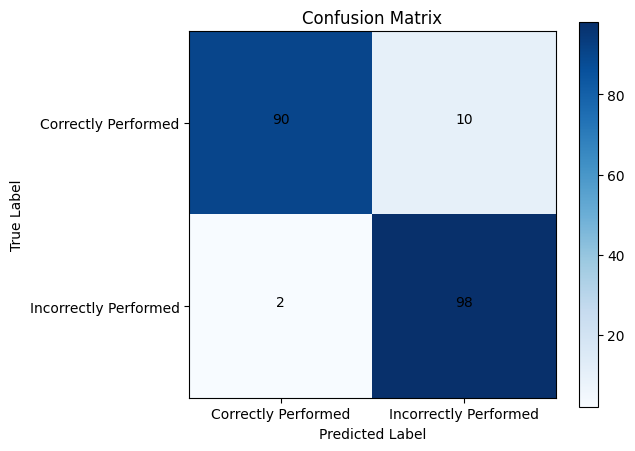

In [16]:
confusion_matrix_s07 = np.array([[29, 71], [ 3, 97]])
confusion_matrix_s09 = np.array([[90, 10], [ 2, 98]])

# Plot the confusion matrix
def plot_confusion_matrix(cm, labels, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center", color="black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Labels for the confusion matrix
labels = ['Correctly Performed', 'Incorrectly Performed']

# Plot
plot_confusion_matrix(confusion_matrix_s09, labels)
plt.show()